In [2]:
import os
import glob
import numpy as np
import torch
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from torch.amp import GradScaler, autocast

In [ ]:
!pip install segmentation-models-pytorch

In [3]:
class PretrainedUNet2D(nn.Module):
    def __init__(self, in_channels=4, num_classes=4, encoder_name='resnet34', pretrained=True):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=encoder_name,                # e.g., 'resnet34'
            encoder_weights='imagenet' if pretrained else None,
            in_channels=in_channels,                  # your input channels (e.g., 4)
            classes=num_classes                       # your output classes (e.g., 4)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
class BrainSegmentationDataset(Dataset):
    def __init__(self, input_dir):
        self.input_files = sorted(glob.glob(os.path.join(input_dir, "InputSlice_*.npz")))
        self.mask_files = sorted(glob.glob(os.path.join(input_dir, "MaskSlice_*.npz")))
        assert len(self.input_files) == len(self.mask_files), "Mismatched input and mask files"
        print(f"Found {len(self.input_files)} input-mask pairs.")

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_data = np.load(self.input_files[idx])
        mask_data = np.load(self.mask_files[idx])

        # Use correct keys — update if not 'arr_0'
        x = input_data['input']  # shape: (H, W, 4)
        y = mask_data['mask']   # shape: (H, W)

        x = np.transpose(x, (2, 0, 1))  # shape: (4, H, W)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [5]:
# ---------- Dice Score ----------
def multiclass_dice_score(preds, targets, num_classes=4, epsilon=1e-6):
    preds = torch.argmax(preds, dim=1)
    dice = 0
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice += (2 * intersection + epsilon) / (union + epsilon)
    return dice / num_classes

In [6]:
# ---------- Visualization ----------
def visualize_prediction(model, dataset, device, index=0):
    model.eval()
    x, y = dataset[index]
    x = x.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x)
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x.squeeze(0)[0].cpu(), cmap='gray')
    axs[0].set_title('Input (Modality 0)')
    axs[1].imshow(y.cpu(), cmap='nipy_spectral')
    axs[1].set_title('Ground Truth')
    axs[2].imshow(pred_mask, cmap='nipy_spectral')
    axs[2].set_title('Prediction')
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
# ---------- Training Config ----------
input_dir = '/kaggle/input/preprocessed-data-spw/Preprocessed_data'  # Folder with .npz files
batch_size = 4
lr = 1e-4
epochs = 33
resume_from_epoch = 40  # set to 0 if not resuming
checkpoint_path = f"/kaggle/input/epoch-{resume_from_epoch}/unet2d_epoch{resume_from_epoch}.pth"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# ---------- Load Data ----------
dataset = BrainSegmentationDataset(input_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

Found 56826 input-mask pairs.


In [9]:
# ---------- Model, Loss, Optimizer ----------
model = PretrainedUNet2D(in_channels=4, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scaler = GradScaler(device='cuda')

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [10]:
if resume_from_epoch > 0:
    print(f"Resuming from epoch {resume_from_epoch}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
# ---------- Training Loop ----------
for epoch in range(resume_from_epoch, epochs):
    model.train()
    total_loss = 0
    start_time = time.time()
    
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            preds = model(x)
            loss = criterion(preds, y)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    duration = (time.time() - start_time) / 60
    print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_loader):.4f}")
    print(f"Time taken: {duration:.2f} minutes")

    # Validation
    model.eval()
    val_dice = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            val_dice += multiclass_dice_score(preds, y).item()
    val_dice /= len(val_loader)
    print(f"Epoch {epoch+1}: Val Dice = {val_dice:.4f}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }, f"/kaggle/working/unet2d_epoch{epoch+1}.pth")
    print(f"Checkpoint saved: unet2d_epoch{epoch+1}.pth")
    
    # torch.save(model.state_dict(), f"/kaggle/working/unet2d_epoch{epoch+1}.pth")
    # print(f"Model saved as unet2d_epoch{epoch+1}.pth")

Resuming from epoch 33...


In [11]:
# ---------- Save Model ----------
torch.save(model.state_dict(), 'unet2d_brain_seg.pth')
print("Model saved as unet2d_brain_seg.pth")

Model saved as unet2d_brain_seg.pth


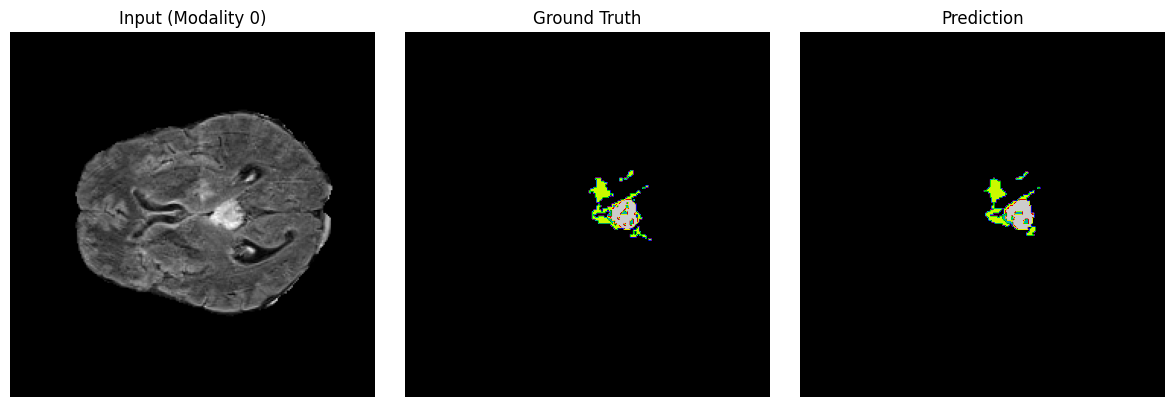

In [12]:
# ---------- Visualize ----------
visualize_prediction(model, val_ds, device, index=0)